In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# libraries to build algorithm
import sys
import numpy as np
from numpy import linalg as la
# libraries to import data
from sklearn.datasets import make_regression
# libraries for plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# libraries for in-built algorithm
import statsmodels.api as sm

In [35]:
# custom classes and functions
sys.path.append('..')
from utils.gradient_descent import GradientDescent
from utils.plotting import plot_regression_data, plot_regression
from utils.metrics import mape

## Algorithm

In [36]:
class SumOfSquares():
    '''inputs:
    X: (n, m)
    y: (n, 1)
    w: (m, 1) - weights'''
    def reg(self, w):
        '''return weights for the regularization term
        i.e. weights with intercept weight = 0 because we do not regularize intercept'''
        w_reg = w.copy()
        w_reg[0] = 0
        return w_reg
    
    def compute_cost(self, X, w, y, reg_lambda):
        y_hat = np.matmul(X, w)
        reg_term = reg_lambda * self.reg(w)**2
        self.cost = ( np.sum((y_hat - y)**2) + np.sum(reg_term) ) / (2*y.shape[0])
    
    def derivative(self, X, w, y, reg_lambda):
        y_hat = np.matmul(X, w)
        reg_term = reg_lambda * self.reg(w)
        return ( np.sum((y_hat - y) * X, axis = 0).reshape(-1,1) + reg_term ) / y.shape[0]
    
class Projection():
    ''' input:
        X: (n, m)
        v: (n, 1)
        regularize: adds regularization term for regression
        fit: returns the coordinates of the projection matrix multiplier by v
        transform: multiply X by the returned value of fit to obtain the projection of v onto X'''
    def regularize(self, Xt_X, reg_lambda):
        '''adds regularization term, excluding intercept'''
        reg_matrix = np.identity(Xt_X.shape[0])
        reg_matrix[0,0] = 0 # removes intercept term from regularization
        Xt_X = Xt_X + reg_lambda * reg_matrix
        return Xt_X
        
    def fit(self, X, v, reg_lambda):
        Xt_X = np.matmul(X.T, X) # shape = Xt: mxn, X: nxm, XtX: mxm
        # add regularization
        Xt_X = self.regularize(Xt_X, reg_lambda)
        Xt_X_inv = la.inv(Xt_X) # shape = mxm
        Xt_X_inv_Xt = np.matmul(Xt_X_inv, X.T) # shape = mxn
        self.coord = np.matmul(Xt_X_inv_Xt, v) # shape = mx1
    
    def transform(self, X):
        return np.matmul(X, self.coord)

class MultipleLinearRegression():
    
    def __init__(self, learning_rate = 0.001, max_iter = 100, threshold = 1e-3, reg_lambda = 0, debug = False, seed = None):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.threshold = threshold
        self.debug = debug
        self.reg_lambda = reg_lambda
        self.seed = seed
    
    def add_intercept(self, X):
        X_zero = np.ones((X.shape[0],1))
        return np.concatenate((X_zero, X), axis=1) 
        
    def fit_normal_equation(self, X, y):
        '''input:
        X: (n, m)
        y: (n, 1)
        where n > m
        fits a line of best fit to data X with equation y = mX using the normal equation'''
        # y_pred is the orthogonal prjection of y onto the column space of X
        y = y.reshape(y.shape[0], 1)
        # add intercept term
        X = self.add_intercept(X)
        # regression params are the coordinates of the projection of y onto X
        projection = Projection()
        projection.fit(X, y, self.reg_lambda)
        self.coef = projection.coord
    
    def fit_gradient_descent(self, X, y, batch_size):
        y = y.reshape(-1, 1)
        # add intercept term
        X = self.add_intercept(X)
        # init weights
        init_w = np.random.randn(X.shape[1],1)/ 2
        # gradient descent with Sum of Squared Residuals as loss
        ss = GradientDescent(X, y, init_w, loss = SumOfSquares(), batch_size = batch_size, reg_lambda = self.reg_lambda, seed = self.seed)
        ss.gradient_descent(learning_rate = self.learning_rate, 
                            max_iter = self.max_iter, 
                            threshold = self.threshold, 
                            debug = self.debug)
        self.coef = ss.w
        
    def fit(self, X, y, method = 'normal_equation', batch_size = None):
        if method == 'normal_equation':
            self.fit_normal_equation(X, y)
        elif method == 'gradient_descent':
            self.fit_gradient_descent(X, y, batch_size)
             
    def predict(self, X_test):
        '''input:
        X_test: (k, m)'''
        # add intercept term
        X_test = self.add_intercept(X_test)
        return np.matmul(X_test, self.coef).reshape(X_test.shape[0],) # shape = (k,)
        

## Load data

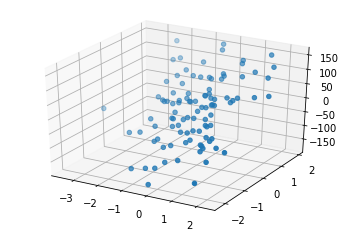

In [37]:
X, y = make_regression(n_samples=100, n_features=2, n_informative=1, n_targets=1, bias = 0, noise = 1)
plot_regression_data(X, y)

In [38]:
X.shape, y.shape

((100, 2), (100,))

## Apply algorithm

In [39]:
# normal equation
reg = MultipleLinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

In [40]:
print('mape: {}'.format(mape(y_pred, y)))

mape: 0.028417609092002093


In [41]:
print('coefficients: {}'.format([i[0] for i in reg.coef]))

coefficients: [-0.11467496019048018, 0.03686008220812642, 78.87084280314181]


In [42]:
plot_regression(X, y, y_pred)

<Figure size 432x288 with 0 Axes>

In [43]:
# gradient descent
reg_gd = MultipleLinearRegression(learning_rate = 0.001, max_iter = 10000)
reg_gd.fit(X, y, method = 'gradient_descent', batch_size = 21)
y_pred_gd = reg_gd.predict(X)

In [44]:
print('mape: {}'.format(mape(y_pred_gd, y)))

mape: 0.028374712217129606


In [45]:
print('coefficients with gradient descent: {}'.format([i[0] for i in reg_gd.coef]))

coefficients with gradient descent: [-0.10715265944363342, 0.03864298973409569, 78.87929436348314]


In [46]:
plot_regression(X, y, y_pred_gd)

<Figure size 432x288 with 0 Axes>

## Compare with in-built algorithm

In [47]:
X_copy = X.copy()
X_copy = sm.add_constant(X_copy)
reg2 = sm.OLS(y, X_copy).fit()
y_pred2 = reg2.predict(X_copy)

In [48]:
print('mape: {}'.format(mape(y_pred2, y)))

mape: 0.02841760909200211


In [49]:
print('coefficients: {}'.format(reg2.params))

coefficients: [-1.14674960e-01  3.68600822e-02  7.88708428e+01]


In [50]:
plot_regression(X, y, y_pred2)

<Figure size 432x288 with 0 Axes>

## With L2 Regularization

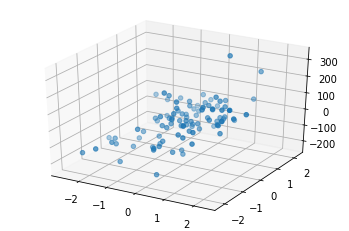

In [51]:
# noisy data
X, y = make_regression(n_samples=100, n_features=2, n_informative=2, n_targets=1, bias = 0, noise = 70)
plot_regression_data(X, y)

In [52]:
# normal equation
# regularized
reg_reg = MultipleLinearRegression(reg_lambda = 1, seed = 0)
reg_reg.fit(X, y, batch_size=1)
y_pred_reg = reg_reg.predict(X)
# non regularized
reg = MultipleLinearRegression(reg_lambda = 0, seed = 0)
reg.fit(X, y, batch_size=1)
y_pred = reg.predict(X)

In [53]:
print('mape regularized: {}'.format(mape(y_pred_reg, y)))
print('mape: {}'.format(mape(y_pred, y)))

mape regularized: 1.7134536757729995
mape: 1.7147844984916423


In [54]:
print('coefficients regularized: {}'.format([i[0] for i in reg_reg.coef]))
print('coefficients: {}'.format([i[0] for i in reg.coef]))

coefficients regularized: [-14.700957697639472, 57.57511361066659, 18.114032841281478]
coefficients: [-14.703447360036689, 58.16735788753084, 18.278218496258326]


In [55]:
# gradient descent
# regularized
reg_gd_reg = MultipleLinearRegression(learning_rate = 0.001, max_iter = 10000, reg_lambda = 1, seed = 0)
reg_gd_reg.fit(X, y, method = 'gradient_descent', batch_size = X.shape[0])
y_pred_gd_reg = reg_gd_reg.predict(X)
# non regularized
reg_gd = MultipleLinearRegression(learning_rate = 0.001, max_iter = 10000, seed = 0)
reg_gd.fit(X, y, method = 'gradient_descent', batch_size = X.shape[0])
y_pred_gd = reg_gd.predict(X)

In [56]:
print('mape regularized: {}'.format(mape(y_pred_gd_reg, y)))
print('mape: {}'.format(mape(y_pred_gd, y)))

mape regularized: 1.7133187662131755
mape: 1.714649637682469


In [57]:
print('coefficients with gradient descent regularized: {}'.format([i[0] for i in reg_gd_reg.coef]))
print('coefficients with gradient descent: {}'.format([i[0] for i in reg_gd.coef]))

coefficients with gradient descent regularized: [-14.699406525322031, 57.57265644078971, 18.11223427437817]
coefficients with gradient descent: [-14.701897127769405, 58.16455693508118, 18.276353575875714]


## Compare with in-built algorithm

In [58]:
X_copy = X.copy()
X_copy = sm.add_constant(X_copy)
reg2 = sm.OLS(y, X_copy).fit_regularized(alpha = 0.01)
y_pred2 = reg2.predict(X_copy)

In [59]:
print('mape: {}'.format(mape(y_pred2, y)))

mape: 1.7137534316174916


In [60]:
print('coefficients: {}'.format(reg2.params))

coefficients: [-14.69166495  58.15800203  18.26605912]
